In [1]:
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, mean_absolute_error
from scikitplot.metrics import plot_roc

In [2]:
class CFG:
    SEED = 768
    BATCH_SIZE = 32
    EPOCHS = 10

# Dataset Exploration

In [3]:
# Load the csv files
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
submission_df = pd.read_csv('./sample_submission.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      60000 non-null  int64 
 1   Review  60000 non-null  object
 2   Rating  60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [5]:
train_df.head()

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [6]:
def view_samples(df, count=5):
    idx = random.sample(train_df.index.to_list(), count)
    print('=========================================\n')
    for _ in idx:
        print(f'id:\t{df.Id[_]}\n')
        print(f'Review:\n{df.Review[_]}\n')
        print(f'Rating:\n{df.Rating[_]}')
        print('=========================================\n')

In [7]:
view_samples(train_df, count=5)


id:	17708

Review:
Its just amazing how we can learn and hae fun at the same time this app is all i needed

Rating:
5

id:	49379

Review:
Usually fine but the last couple of items I’ve ordered they have sent the wrong item. Tried to phone to resolve issue and was put on hold for 20 minutes before being cut off with no return call

Rating:
3

id:	9701

Review:
Very poor customer service. Item never arrived have to wait almost 2 weeks for refund and then will take 3 days to arrive in my bank. Customer service unhelpful. Would never use again.

Rating:
1

id:	535

Review:
I must say, initially I was quite pleased with PC Specialist, but decided to hold off leaving a review until I'd used the PC for a while. Now, faults happen, and I don't think any company should be marked down for that; it's the way they respond that's important. Sadly, it has been a terrible experience, especially for a PC that cost over £6,000. A few faults occurred (the most important being only half the RAM started 

View Train Rating Distribution

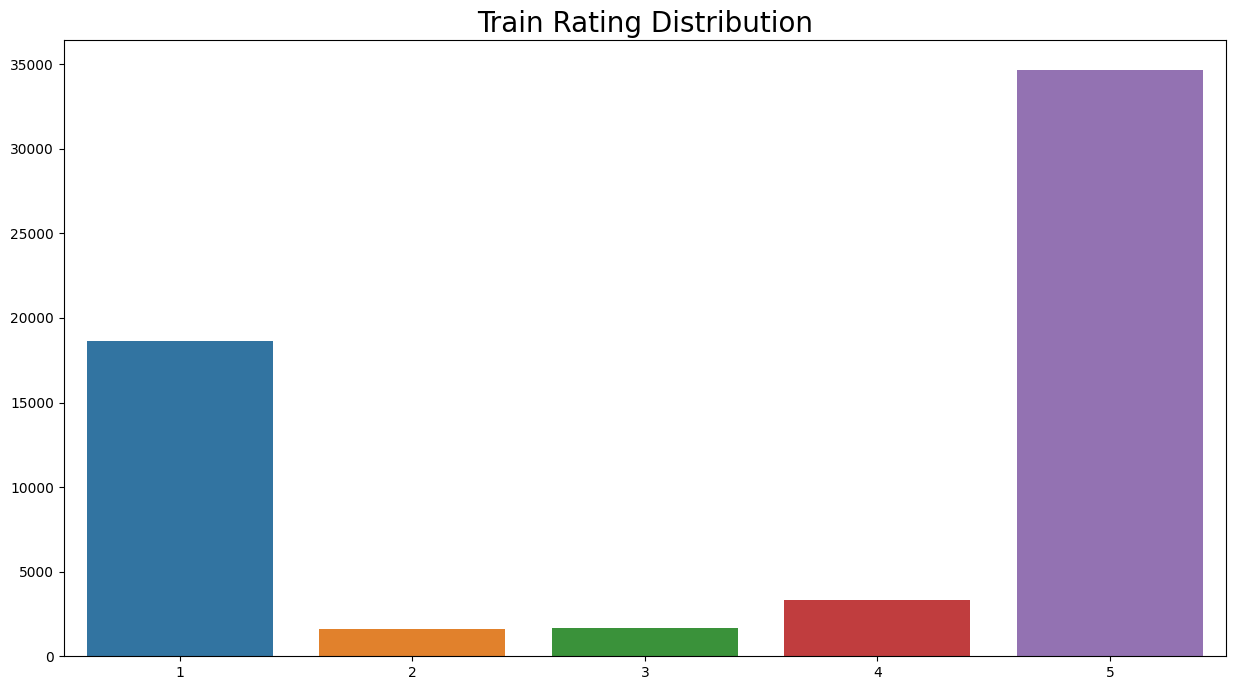

In [8]:
# View Train Rating Distribution
plt.figure(figsize=(15, 8))
plt.title('Train Rating Distribution', fontsize=20)

train_distribution = train_df['Rating'].value_counts().sort_values()
sns.barplot(x=list(train_distribution.keys()),
            y=train_distribution.values);

In [9]:
# Get the lengths of each review
train_df['review_length'] = [len(_) for _ in train_df.Review]

# Get the number of tokens per review 
train_df['token_count'] = [len(_.split()) for _ in train_df.Review]

In [10]:
train_df.head(5)

,Id,Review,Rating,review_length,token_count
0,0,Very good value and a great tv very happy and ...,5,89,18
1,1,After 6 month still can't access my account,3,43,8
2,2,I couldn't make an official review on a produc...,1,496,92
3,3,"Fantastic! Extremely easy to use website, fant...",5,197,32
4,4,So far annoyed as hell with this bt monthly pa...,1,222,49


In [11]:
print('Review Length Description')
print('==================================')
print(train_df['review_length'].describe())
print('==================================')

Review Length Description
count    60000.000000
mean       309.070083
std        423.772492
min         31.000000
25%         82.000000
50%        164.000000
75%        358.000000
max       7794.000000
Name: review_length, dtype: float64


In [12]:
# Inspect Token Count Stats
print('Token Count Description')
print('==================================')
print(train_df['token_count'].describe())
print('==================================')

Token Count Description
count    60000.00000
mean        56.56325
std         79.35289
min          1.00000
25%         14.00000
50%         29.00000
75%         66.00000
max       1439.00000
Name: token_count, dtype: float64


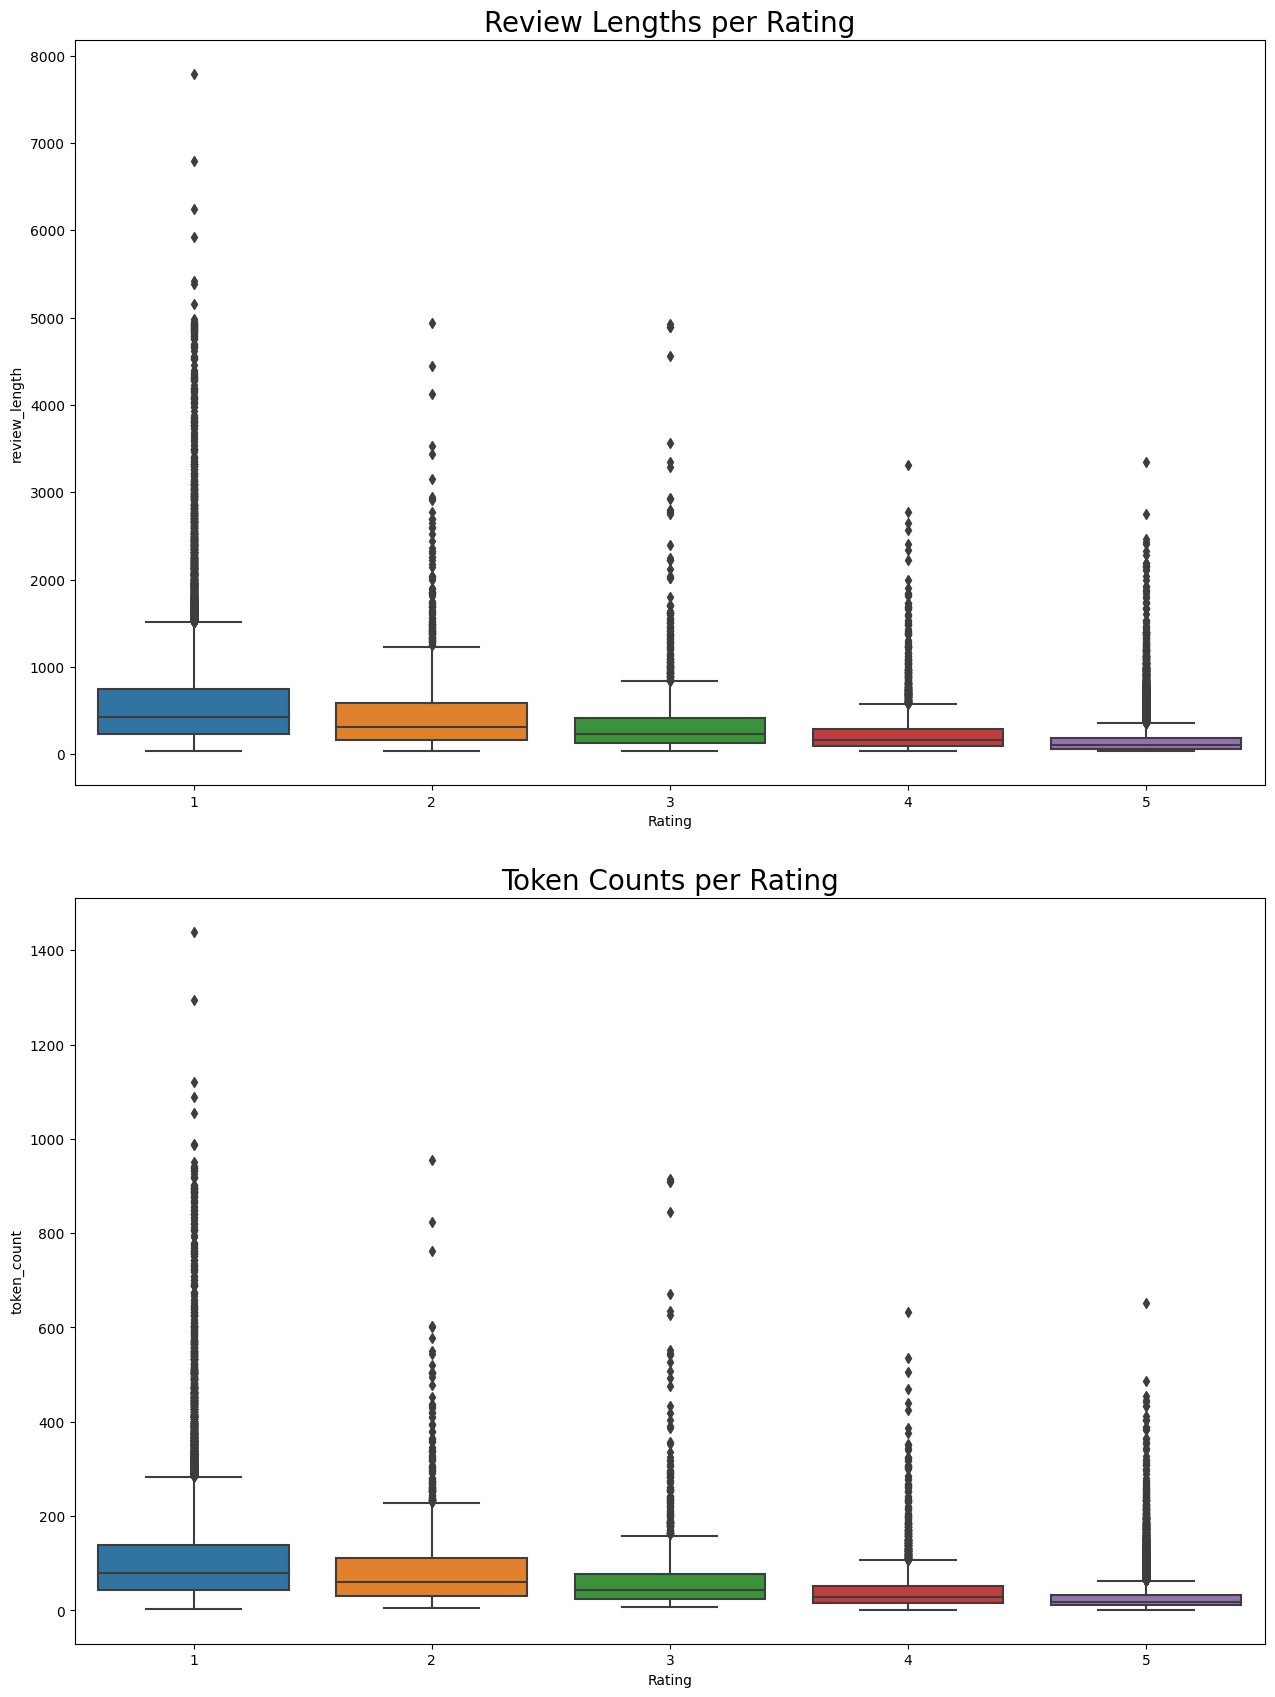

In [13]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 18))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Range of Review Lengths per Rating
ax1.set_title('Review Lengths per Rating', fontsize=20)
sns.boxplot(data=train_df, y='review_length', x='Rating',
            ax=ax1)

# Plot Range of Token Counts per Rating
ax2.set_title('Token Counts per Rating', fontsize=20)
sns.boxplot(data=train_df, y='token_count', x='Rating',
            ax=ax2);

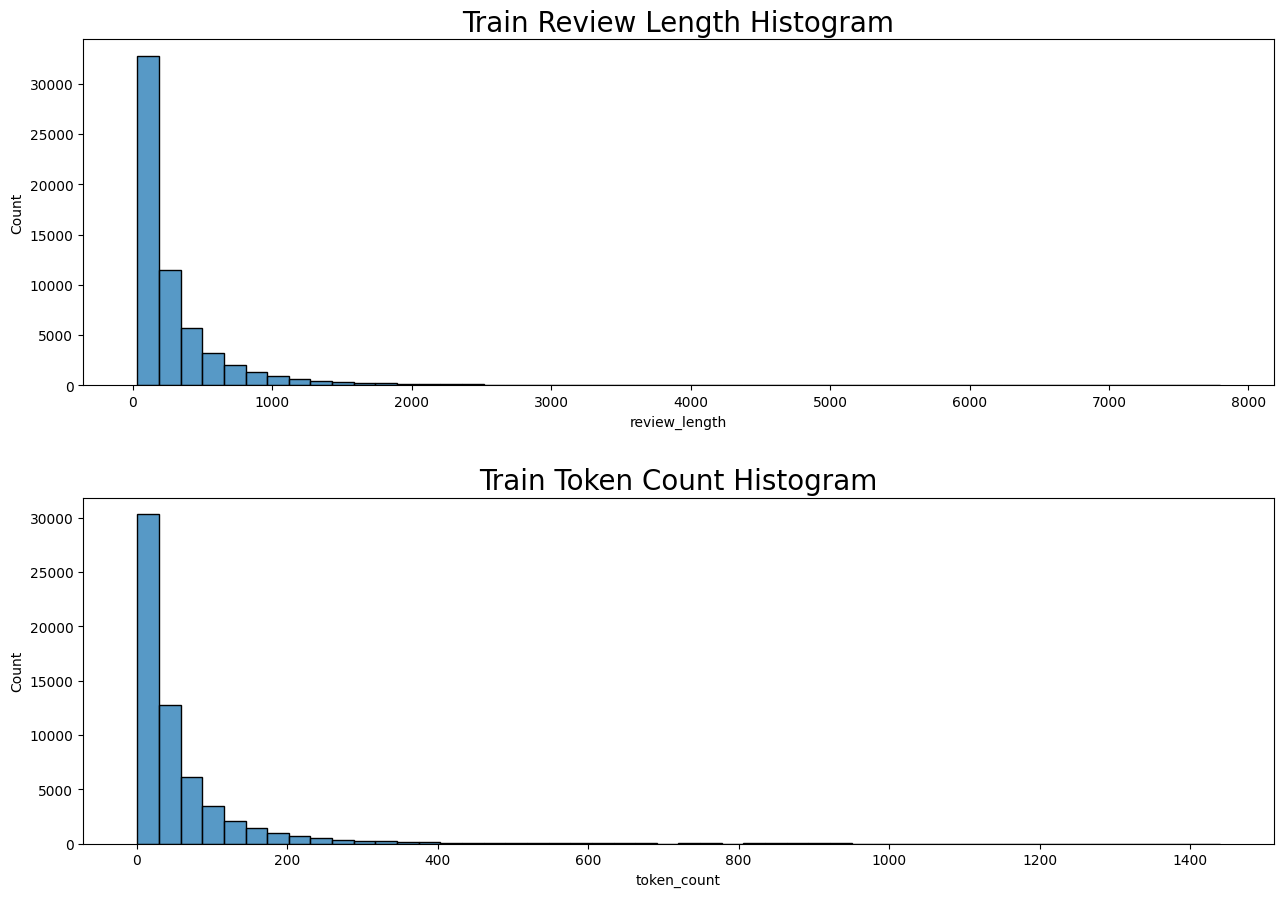

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Generate Train Rating Histogram
ax1.set_title('Train Review Length Histogram', fontsize=20)
sns.histplot(data=train_df, x='review_length', bins=50,
            ax=ax1)

# Generate Train Token Count Histogram
ax2.set_title('Train Token Count Histogram', fontsize=20)
sns.histplot(data=train_df, x='token_count', bins=50,
            ax=ax2);

# Data Preprocessing

In [15]:
train_df["rating_encoded"] = train_df['Rating'] - 1

In [16]:
train_idx, val_idx, _, _ = train_test_split(
    train_df.index, train_df.Rating, 
    test_size=0.2, stratify=train_df.Rating,
    random_state=CFG.SEED
)

In [17]:
train_new_df = train_df.iloc[train_idx].reset_index(drop=True)
val_df = train_df.iloc[val_idx].reset_index(drop=True)
# View shapes
train_new_df.shape, val_df.shape

((48000, 6), (12000, 6))

In [18]:
# View new train dataframe
train_new_df

,Id,Review,Rating,review_length,token_count,rating_encoded
0,7372,Straight forward purchase from trusted supplie...,5,80,12,4
1,36260,Website is super smooth and easy to navigate w...,5,118,21,4
2,33497,"Apparently it was posted twice, maybe it will ...",1,150,26,0
3,36775,Order received the day after order. Memory upg...,5,94,15,4
4,49630,"Its great, in a contract with them for 30GB fo...",5,162,27,4
...,...,...,...,...,...,...
47995,40748,I have made 2 purchases with PCSPECIALIST in t...,5,91,17,4
47996,33270,Matress is amazing- thank you\nYet again deliv...,2,402,78,1
47997,16802,Gtech have a great product I always buy from t...,5,134,25,4
47998,37531,"Quick delivery, competitive price",5,33,4,4


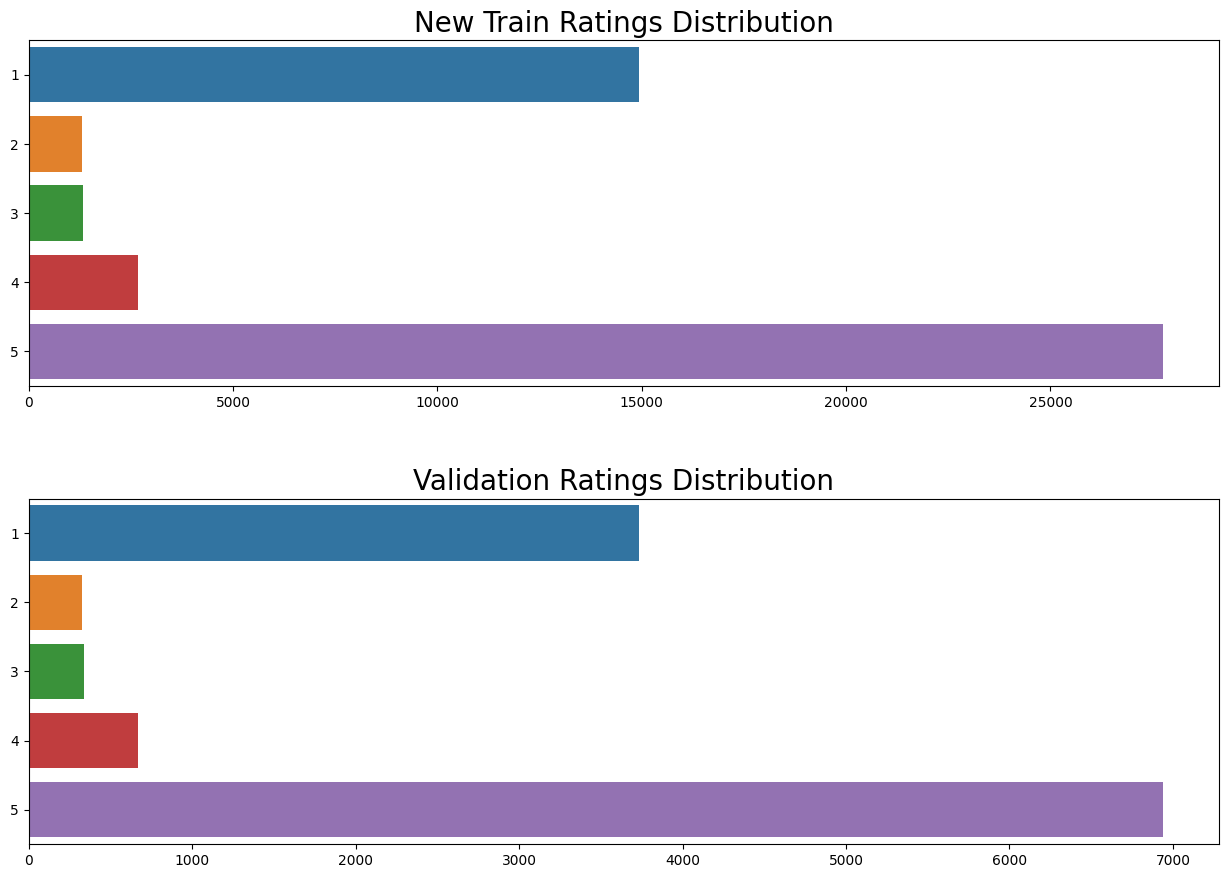

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot New Train Ratings Distribution
ax1.set_title('New Train Ratings Distribution', fontsize=20)
train_new_distribution = train_new_df['Rating'].value_counts().sort_values()
sns.barplot(x=train_new_distribution.values,
            y=list(train_new_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Validation Ratings Distribution
ax2.set_title('Validation Ratings Distribution', fontsize=20)
val_distribution = val_df['Rating'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

# Build Input Data Pipeline with tf.data API

In [20]:
def text_preprocessor(text):
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
   
    non_ascii_pattern = re.compile(r"[^\x00-\x7F]+", flags=re.UNICODE)
    digit_pattern = re.compile('[0-9]', flags=re.UNICODE)
    
    link_pattern = re.compile('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', flags=re.UNICODE)
    preprocessed_text = emoji_pattern.sub(r'', text)
    # Remoce non-ascii characters
    preprocessed_text = non_ascii_pattern.sub(r'', preprocessed_text)
    # Replace numbers with '@' sign
    preprocessed_text = digit_pattern.sub(r'#', preprocessed_text)
    # Remove web links 
    preprocessed_text = link_pattern.sub(r'', preprocessed_text)
    
    return preprocessed_text

## Generate Input Data Pipelines

In [21]:
def encode_labels(labels, label_depth=5):
    return tf.one_hot(labels, depth=label_depth).numpy()

def create_pipeline(df, preprocessor, batch_size=32, shuffle=False, cache=None, prefetch=False):
    reviews = df['Review'].apply(preprocessor).to_numpy().astype(str)
    ratings = encode_labels(df['rating_encoded'].to_numpy().astype(np.float32))
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((reviews, ratings))
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [22]:
# Create train input data pipeline
train_ds = create_pipeline(
    train_new_df, text_preprocessor, 
    batch_size=CFG.BATCH_SIZE, 
    shuffle=False, prefetch=True
)

# Create validation input data pipeline
val_ds = create_pipeline(
    val_df, text_preprocessor,
    batch_size=CFG.BATCH_SIZE, 
    shuffle=False, prefetch=False
)

In [23]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


# Baseline Model: Universal Sentence Encoder Model

In [24]:
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [26]:
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'

encoder_trainable=False # set trainable to False for inference-only 

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

## Build Model

In [27]:
def build_baseline_model(num_classes=5):
    # Define kernel initializer & input layer
    initializer = tf.keras.initializers.HeNormal(seed=CFG.SEED)
    review_input = layers.Input(shape=[], dtype=tf.string, name='review_text_input')
    
    # Generate Embeddings
    review_embedding = encoder(review_input)
    
    # Feed Embeddings to a Bidirectional LSTM
    expand_layer = layers.Lambda(lambda embed: tf.expand_dims(embed, axis=1))(review_embedding)
    bi_lstm = layers.Bidirectional(layers.LSTM(128, kernel_initializer=initializer), 
                                   name='bidirection_lstm')(expand_layer)
    
    # Feed LSTM output to classification head
    dropout_layer = layers.Dropout(0.25)(bi_lstm)
    dense_layer = layers.Dense(64, activation='relu', kernel_initializer=initializer)(dropout_layer)
    output_layer = layers.Dense(num_classes, activation='softmax', 
                                kernel_initializer=initializer, 
                                name='output_layer')(dense_layer)
    
    return tf.keras.Model(inputs=[review_input], 
                          outputs=[output_layer], 
                          name='use_model')

In [32]:
# Build model
model1 = build_baseline_model()

# View summary of model
model1.summary()

Model: "use_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 review_text_input (InputLa  [(None,)]                 0         
 yer)                                                            
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 lambda_1 (Lambda)           (None, 1, 512)            0         
                                                                 
 bidirection_lstm (Bidirect  (None, 256)               656384    
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                         

# Train Baseline Model


In [38]:
def train_model(model1, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model1.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model1.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

In [39]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

## Compile & Train Model

In [40]:
tf.random.set_seed(CFG.SEED)

model1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model1.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

model_history = train_model(
    model1, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training use_model.
Train on 48000 samples, validate on 12000 samples.
----------------------------------
Epoch 1/10



1500/1500 [==============================] - 75s 44ms/step - loss: 0.7271 - accuracy: 0.8549 - val_loss: 0.6951 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 2/10
1500/1500 [==============================] - 60s 40ms/step - loss: 0.6934 - accuracy: 0.8652 - val_loss: 0.6899 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 3/10
1500/1500 [==============================] - 61s 40ms/step - loss: 0.6851 - accuracy: 0.8681 - val_loss: 0.6871 - val_accuracy: 0.8676 - lr: 0.0010
Epoch 4/10
1500/1500 [==============================] - 61s 41ms/step - loss: 0.6782 - accuracy: 0.8705 - val_loss: 0.6856 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 5/10
1500/1500 [==============================] - 60s 40ms/step - loss: 0.6715 - accuracy: 0.8725 - val_loss: 0.6839 - val_accuracy: 0.8685 - lr: 0.0010
Epoch 6/10
1500/1500 [==============================] - 60s 40ms/step - loss: 0.6652 - accuracy: 0.8748 - val_loss: 0.6836 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 7/10
1500/1500 [==============================] - 5

In [43]:
# Evaluate the model
model_evaluation = model1.evaluate(val_ds)

375/375 [==============================] - 9s 23ms/step - loss: 0.6823 - accuracy: 0.8696


In [44]:
# Generate model probabilities and associated predictions
train_probabilities = model1.predict(train_ds, verbose=1)
train_predictions = tf.argmax(train_probabilities, axis=1)

1500/1500 [==============================] - 39s 24ms/step


In [45]:
# Generate model probabilities and associated predictions
val_probabilities = model1.predict(val_ds, verbose=1)
val_predictions = tf.argmax(val_probabilities, axis=1)

375/375 [==============================] - 9s 24ms/step


In [47]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

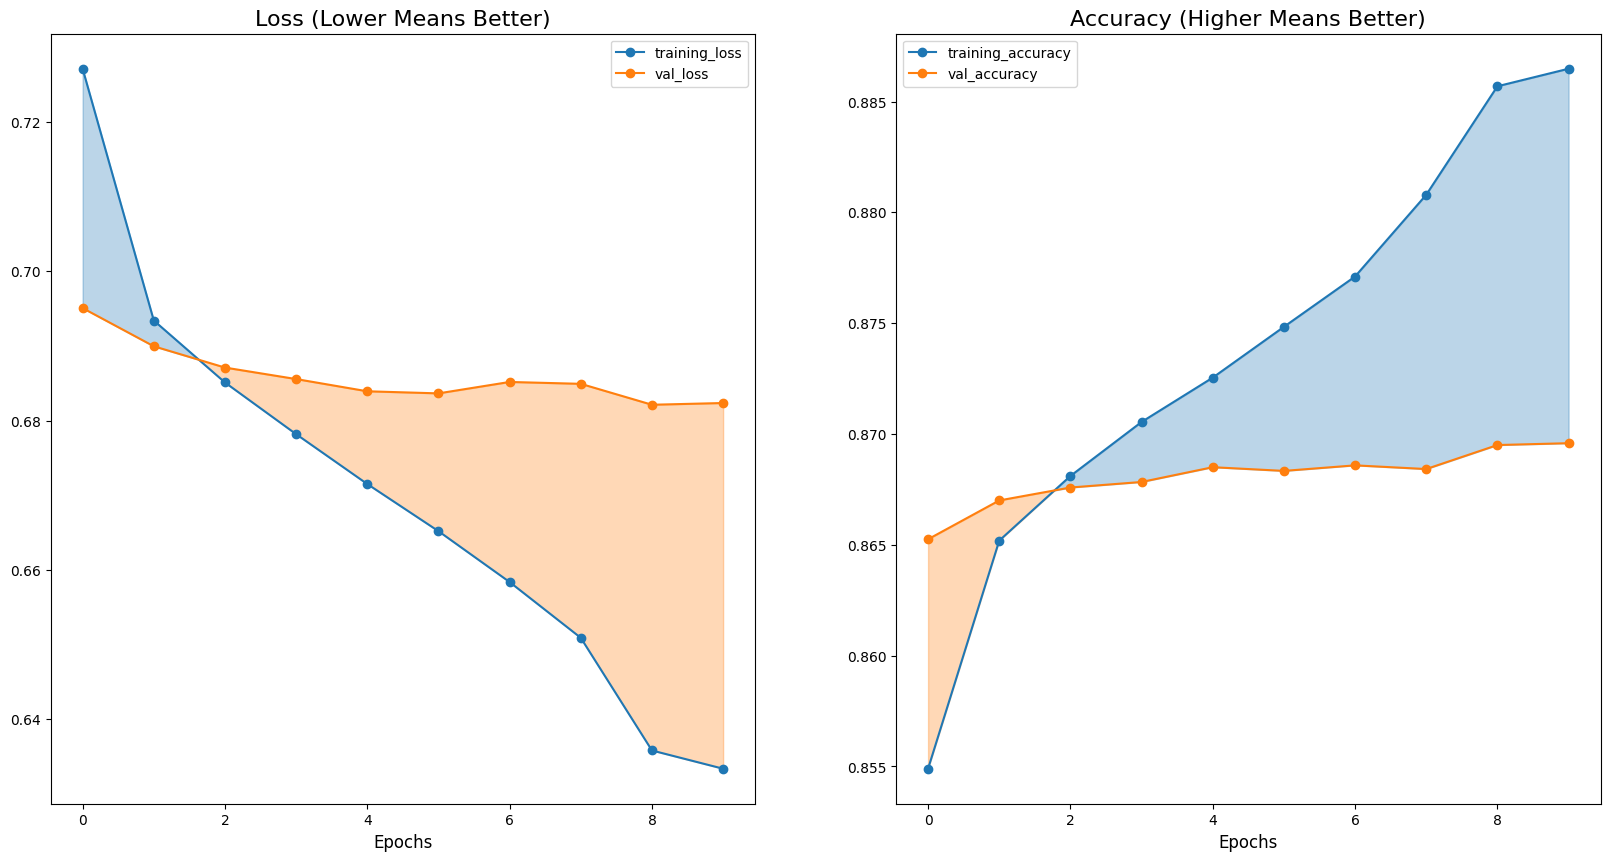

In [48]:
plot_training_curves(model_history)

In [49]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

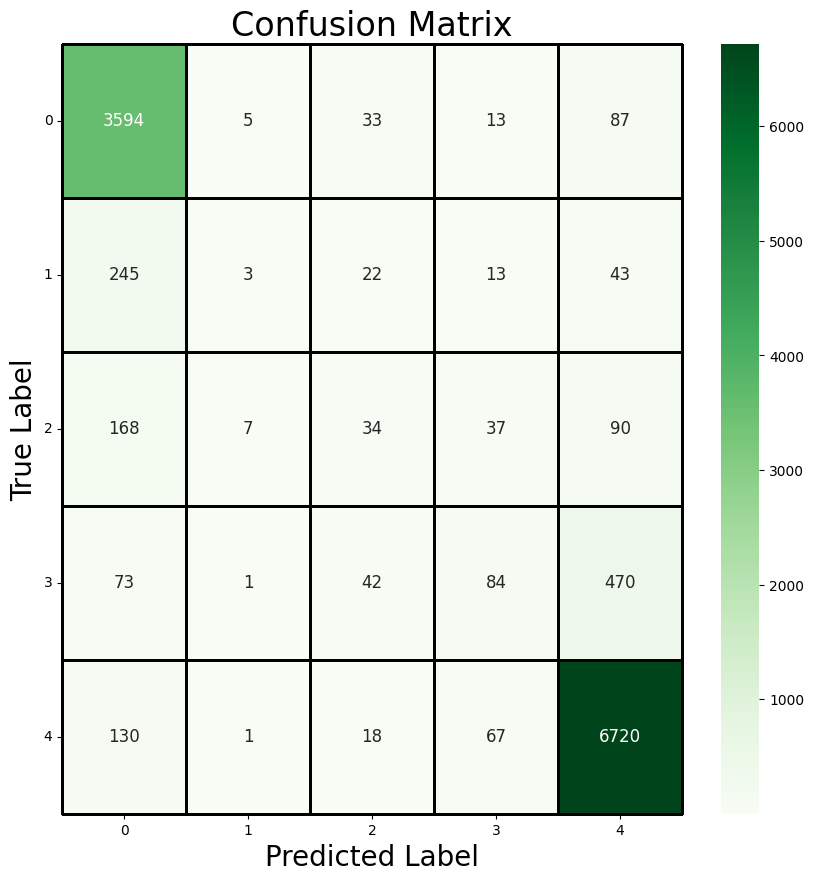

In [50]:
plot_confusion_matrix(
    val_df.Rating - 1, 
    val_predictions, 
    figsize=(10, 10))

In [51]:
print(classification_report(val_df.Rating - 1, val_predictions))

              precision    recall  f1-score   support

           0       0.85      0.96      0.91      3732
           1       0.18      0.01      0.02       326
           2       0.23      0.10      0.14       336
           3       0.39      0.13      0.19       670
           4       0.91      0.97      0.94      6936

    accuracy                           0.87     12000
   macro avg       0.51      0.43      0.44     12000
weighted avg       0.82      0.87      0.84     12000



In [52]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_2_accuracy = top_k_accuracy_score(y_true, y_probabilities, k=2)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, 
                                                                                 y_pred, 
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.5f}\n')
    print('_____________________________________________')
    print(f'top_2_accuracy_score:\t{top_2_accuracy:.5f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.5f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.5f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.5f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.5f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score': model_accuracy,
        'top_2_accuracy_score': top_2_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    
    return preformance_scores

In [53]:
model_performance = generate_preformance_scores(val_df.Rating-1, val_predictions, val_probabilities)


Performance Metrics:

accuracy_score:		0.86958

_____________________________________________
top_2_accuracy_score:	0.94433

_____________________________________________
precision_score:	0.82277

_____________________________________________
recall_score:		0.86958

_____________________________________________
f1_score:		0.83798

_____________________________________________
matthews_corrcoef:	0.76068



In [54]:
# Inspect Competition Metric: Mean-Absolute-Error
print('Competition Metric Score')
print('=========================')
print(f'Train MAE:\t{mean_absolute_error(train_new_df.rating_encoded, train_predictions):.5f}')
print(f'Validation MAE:\t{mean_absolute_error(val_df.rating_encoded, val_predictions):.5f}')
print('=========================')

Competition Metric Score
Train MAE:	0.18440
Validation MAE:	0.23325


# Generate Submission


In [55]:
def predict(model, test_reviews):
    probabilities = model.predict(test_reviews, verbose=1)
    predictions = tf.argmax(probabilities, axis=1)
    return probabilities, predictions

In [56]:
# Preprocess Test Reviews
test_reviews = test_df['Review'].apply(text_preprocessor)
test_reviews.shape

(40000,)

In [58]:
# Generate Test Predictions
test_probabilities, test_predictions = predict(model1, test_reviews)

1250/1250 [==============================] - 33s 25ms/step


In [59]:
submission_df['Rating'] = test_predictions + 1
submission_df.head(5)

,Id,Rating
0,60000,1
1,60001,5
2,60002,1
3,60003,5
4,60004,1


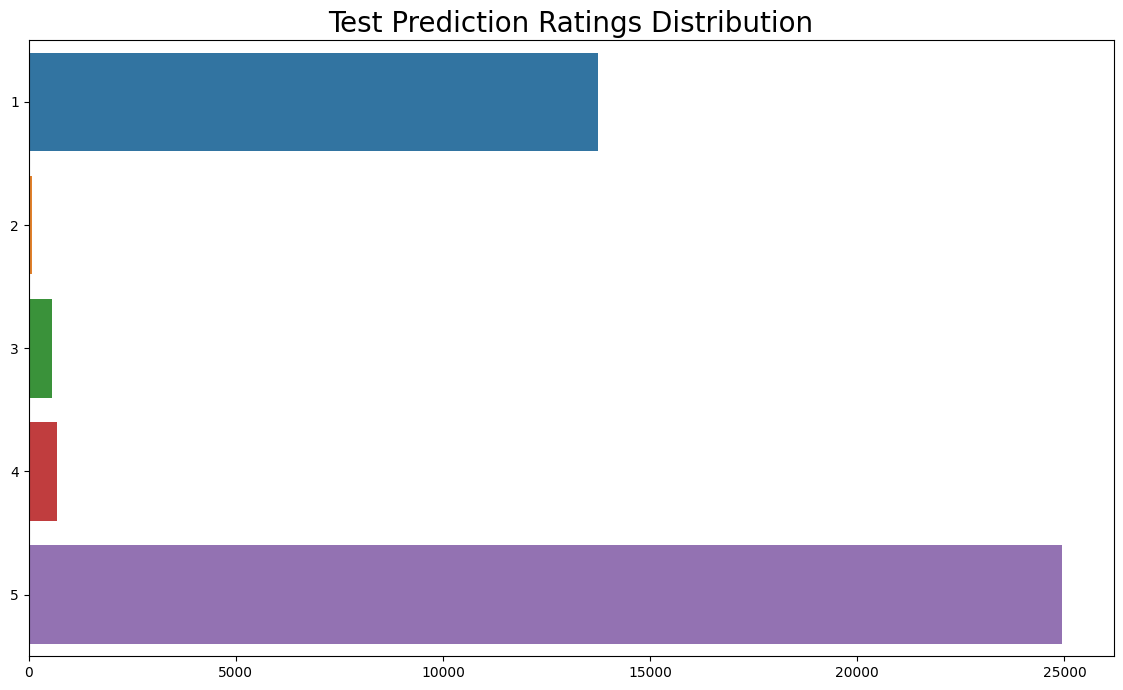

In [60]:
plt.figure(figsize=(14, 8))
plt.title('Test Prediction Ratings Distribution', fontsize=20)
test_predictions_distribution = submission_df['Rating'].value_counts().sort_values()

sns.barplot(x=test_predictions_distribution.values,
            y=list(test_predictions_distribution.keys()),
            orient="h");

In [61]:
# Create submission csv
submission_df.to_csv('submission.csv', index=False)